In [1]:
import numpy as np
import sys
from scipy.stats import entropy
from scipy.special import rel_entr
from scipy.spatial.distance import cdist
import torch,torch.optim, torch.nn
import sklearn.datasets

/home/manuel/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def get_p_scores(X, perp, need_conditionals = False):
    
    N = len(X)
    
    target_h = np.log(perp)
    
    betas_max = np.ones(N)
    betas_min = np.ones(N)
    betas = np.ones(N)
    
    betas_max[:] = 10000
    betas_min[:] = 1
    
    betas[:] = (betas_max + betas_min) / 2
     
    conditionals = get_conditionals(X, betas)
    actual_h = entropy(conditionals, axis = 1)
    
    tolerance = 0.00001
    
    while np.sum(np.abs(actual_h - target_h) > tolerance) > 0:
        
        greater = (actual_h - target_h) > tolerance
        
        betas_max[greater] = betas[greater]
        
        lesser = (actual_h - target_h) < tolerance
        
        betas_min[lesser] = betas[lesser]
        
        need_change = np.abs(actual_h - target_h) > tolerance
        
        betas[need_change] = (betas_max[need_change] + betas_min[need_change]) / 2
        
        conditionals = get_conditionals(X, betas)
        
        actual_h = entropy(conditionals, axis = 1)
        
    probs_sym = (conditionals.T + conditionals) / (2 * len(X))

    return probs_sym

def get_conditionals(X, betas):
    
    dists = (cdist(X, X)**2) / betas[:, None]
    
    exp = np.exp(-dists)
    np.fill_diagonal(exp, 0)
    
    row_sums = np.sum(exp, axis = 1)[:, None]
    exp /= row_sums
    
    return exp

def compute_cost(p_scores, q_scores):
    eps=1e-7
    kl_loss = torch.nn.KLDivLoss(reduction = "sum", log_target = True)
    return kl_loss(torch.log(q_scores + eps), torch.log(p_scores + eps))


def get_q_scores(Y):
    
    q_scores = (torch.cdist(Y, Y)**2 + 1) **-1
    q_scores.fill_diagonal_(0)
            
    q_scores /= q_scores.sum()
    
    return q_scores

def init_y(X):
    return torch.tensor(np.random.normal(size = (len(X), 2), scale = 1.0))


In [8]:
dataset = sklearn.datasets.load_digits()

X = dataset['data']
T = dataset['target']
R = np.random.mtrand.RandomState(0).permutation(len(X))[:750]
X = X[R]
T = T[R]

p_scores = torch.tensor(get_p_scores(X, 60))
y = init_y(X)
y.requires_grad_(True)
print(y)

tensor([[ 0.7456, -0.0332],
        [ 0.3298, -0.1817],
        [-1.0316,  0.0406],
        ...,
        [ 1.0405,  0.5799],
        [-1.8111, -1.3646],
        [-0.7300, -1.0547]], dtype=torch.float64, requires_grad=True)


In [9]:
optimizer = torch.optim.SGD((y,), lr=100, momentum=0.95)

In [10]:
for i in range(500):
    # print(y)
    q_scores = get_q_scores(y)
    # print(q_scores)
    optimizer.zero_grad()
    J = compute_cost(p_scores, q_scores)
    print(J.data.numpy())
    
    J.backward()
    
    optimizer.step()
    # print(y)

2.5666724425671794
2.5486000124882544
2.512495515958356
2.4580890045746764
2.3865007145441757
2.305145623158376
2.2318356468428373
2.175634395199599
2.128826977986837
2.0788395602341243
2.0188022581998757
1.9503672992525138
1.878252492058271
1.807030819122326
1.7386591225211472
1.6710428140669145
1.6047724628401048
1.5443514207489106
1.4903456628703489
1.4421007338582
1.4002210746861106
1.3634091870224112
1.3293080573346372
1.2976697116438307
1.2685765620970388
1.241327328943175
1.2150541214500832
1.1900895257662771
1.167388849851586
1.148680990734886
1.1335733936098444
1.1198737347923153
1.1060244730980822
1.0923326933134287
1.0798980607942146
1.0692404190134694
1.0599031325545003
1.0511484831105262
1.0423252273208363
1.0330992787419304
1.0236687544313474
1.014562502053864
1.0065720031429288
0.9997181247975397
0.9933626231415774
0.9870564532952052
0.9807884534803307
0.9747120238036683
0.9687550244915059
0.9628456498759014
0.9571714864959477
0.9518402136716944
0.9466928143152764
0.9416

0.5661510940866585
0.5660508480558926
0.5659705302297469
0.5659056954057395
0.5658440954678184
0.565775436421356
0.5656946446437017
0.5655992888734058
0.5654882068503783
0.5653624602374888
0.5652268017235328
0.5650897021094285
0.5649605528833908
0.5648447217328201
0.5647413316669361
0.5646477501643712
0.5645640501952494
0.5644900168529934
0.5644212144636145
0.5643504169704884
0.5642713412772263
0.5641810531421767
0.5640804896665783
0.5639735421561293
0.5638651154022833
0.5637589291028389
0.5636562586531966
0.563556411650902
0.5634583654271778
0.5633618929777742
0.5632674335262199
0.5631756283386465
0.5630873500555977
0.5630039321487308
0.5629267881570146
0.5628562449320756
0.5627905235051728
0.5627259486810063
0.5626583404477536
0.5625845518513648
0.5625033003336507
0.5624151510248624
0.5623219241470874
0.5622258797178927
0.5621289796262032
0.5620324257538022
0.5619365637975424
0.561841131863658
0.5617457460459192
0.5616504629638301
0.5615561519235582
0.5614643549312537
0.5613766152150

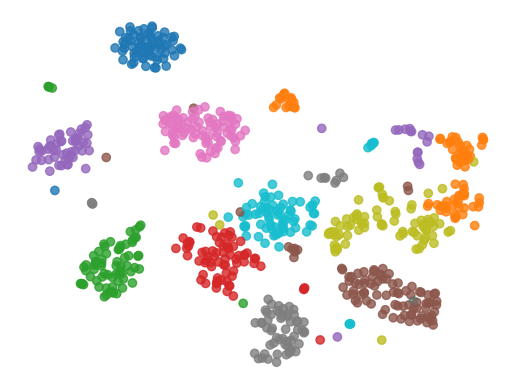

In [11]:
from matplotlib import pyplot as plt

# ax = fig.add_subplot(111)
plt.axis("off")

plt.scatter(y.detach().numpy()[:,0], y.detach().numpy()[:,1], c = T, cmap = "tab10", alpha = 0.8)
plt.savefig("T-SNE.pdf")